# Introducción al simulador RMS VSC-HVDC (MaxVSC-SW)

Este notebook muestra cómo:

- Cargar parámetros y escenario desde ficheros JSON.
- Ejecutar una simulación RMS con la API pública.
- Visualizar resultados (corrientes, tensión DC, etc.).
- (Opcional) Exportar resultados a CSV/Parquet.

> **Nota:** este notebook no modifica el modelo ni la ingeniería.  
> Solo usa la API pública del simulador.


## Prerrequisitos

Antes de usar este notebook:

1. Tener instalado el paquete `vscsim` (modo editable en este repo):

   ```bash
   pip install -e .
Disponer de dos ficheros JSON de entrada compatibles con la CLI:

params.json → parámetros del modelo/control.

scenario.json → definición del escenario (referencias, tensiones, etc.).

Son los mismos que usa la CLI:

bash
Copiar código
vscsim --params params.json --scenario scenario.json ...
pgsql
Copiar código

In [4]:
import json
from pathlib import Path

import matplotlib.pyplot as plt

from vscsim.api.simulation import run_simulation
from vscsim.utils.logger import configure_global_logger_from_config
from vscsim.utils.exporter import (
    export_simulation_csv,
    export_simulation_parquet,
    ExportConfig,
)


In [5]:
from pathlib import Path
import json

def load_json(path: Path) -> dict:
    with path.open("r", encoding="utf-8") as f:
        return json.load(f)

# 📂 Usar los JSON oficiales del repositorio
params_path = Path("../tests/data/params.json")
scenario_path = Path("../tests/data/scenario.json")

print("Params:", params_path.resolve())
print("Scenario:", scenario_path.resolve())

params_config = load_json(params_path)
scenario_config = load_json(scenario_path)

# Vista rápida
list(params_config.keys()), list(scenario_config.keys())


Params: C:\Users\ajrcj\MaxDEV Projects\MaxVSC_sw\tests\data\params.json
Scenario: C:\Users\ajrcj\MaxDEV Projects\MaxVSC_sw\tests\data\scenario.json


(['L', 'R', 'Cdc', 'omega', 'V_max', 'Kp_id', 'Kp_iq'],
 ['control_mode',
  'P_ref',
  'Q_ref',
  'v_pcc_d',
  'v_pcc_q',
  'initial_conditions'])

In [6]:
from pathlib import Path
import json

def load_json(path: Path) -> dict:
    with path.open("r", encoding="utf-8") as f:
        return json.load(f)

# 📌 Rutas desde notebooks/ hacia tests/data/
params_path = Path("../tests/data/params.json")
scenario_path = Path("../tests/data/scenario.json")

params_config = load_json(params_path)
scenario_config = load_json(scenario_path)

list(params_config.keys()), list(scenario_config.keys())


(['L', 'R', 'Cdc', 'omega', 'V_max', 'Kp_id', 'Kp_iq'],
 ['control_mode',
  'P_ref',
  'Q_ref',
  'v_pcc_d',
  'v_pcc_q',
  'initial_conditions'])

## Configuración básica de simulación

La API pública `run_simulation` expone:

- `params_config` : parámetros del modelo/control.
- `scenario_config` : escenario (modos, referencias, tensiones, etc.).
- `t_end` : tiempo final de simulación.
- `dt` : paso fijo o paso inicial si se usa dt adaptativo.
- `integrator` : `"euler"`, `"rk1"`, `"rk2"`, `"rk4"`.
- `adaptive` : `False` para dt fijo, `True` para dt adaptativo.

Los parámetros NR (tolerancia, iteraciones, etc.) se configuran
dentro de `params_config` mediante las claves:

- `nr_tol`
- `nr_max_iter`
- `nr_norm` (`"max"` o `"l2"`)
- `nr_verbose` (`True/False`)


In [7]:
# Configuración de tiempo / solver
t_end = 0.5   # segundos
dt = 1e-3     # paso fijo o inicial

integrator = "rk4"      # "euler", "rk1", "rk2", "rk4"
adaptive = False        # True -> usa dt adaptativo (run_simulation_adaptive internamente)

# Opcional: parámetros NR (solo si quieres sobreescribir lo del JSON)
# IMPORTANTE: no meter strings en params_config, el loader los convierte a float.
if "params_config" in globals():
    params_config.setdefault("nr_tol", 1e-8)
    params_config.setdefault("nr_max_iter", 20)
    # NO usar strings aquí:
    # params_config.setdefault("nr_norm", "max")
    # params_config.setdefault("nr_verbose", False)


In [8]:
results = run_simulation(
    params_config=params_config,
    scenario_config=scenario_config,
    t_end=t_end,
    dt=dt,
)

# Estructura esperada:
# {
#   "time": [...],
#   "x": [ { "id": ..., "iq": ..., "Vdc": ... }, ... ],
#   "y": [ { "Idc": ..., "P_ac": ..., "Q_ac": ... }, ...],
#   ...
# }

list(results.keys())


['time', 'x', 'y']

In [9]:
time = results["time"]
x_hist = results["x"]
y_hist = results["y"]

len(time), len(x_hist), len(y_hist)


(501, 3, 3)

## Visualización básica de resultados

Vamos a representar:

- Corrientes `id`, `iq`
- Tensión DC `Vdc`
- Potencias `P_ac`, `Q_ac` (si están en `y`).


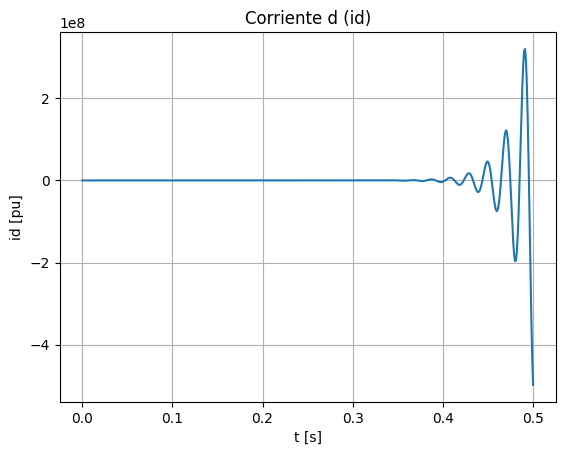

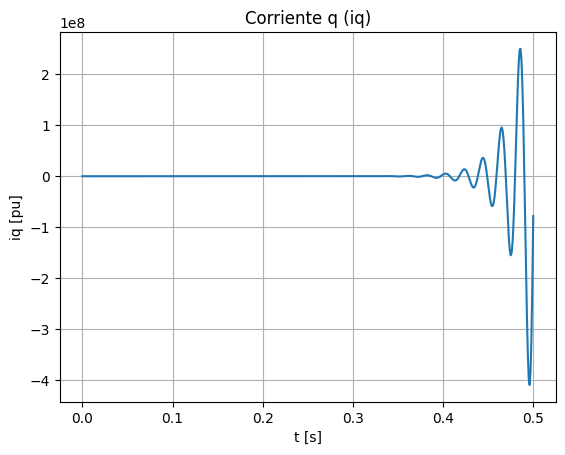

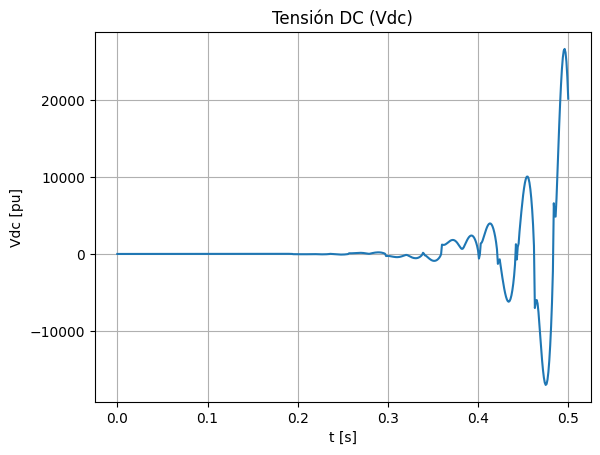

In [10]:
# Extraemos directamente las series desde los diccionarios
time = results["time"]
x_hist = results["x"]   # dict: clave -> lista de valores
y_hist = results["y"]   # dict: clave -> lista de valores

id_series = x_hist.get("id", [])
iq_series = x_hist.get("iq", [])
vdc_series = x_hist.get("Vdc", [])

plt.figure()
plt.plot(time, id_series)
plt.xlabel("t [s]")
plt.ylabel("id [pu]")
plt.title("Corriente d (id)")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(time, iq_series)
plt.xlabel("t [s]")
plt.ylabel("iq [pu]")
plt.title("Corriente q (iq)")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(time, vdc_series)
plt.xlabel("t [s]")
plt.ylabel("Vdc [pu]")
plt.title("Tensión DC (Vdc)")
plt.grid(True)
plt.show()


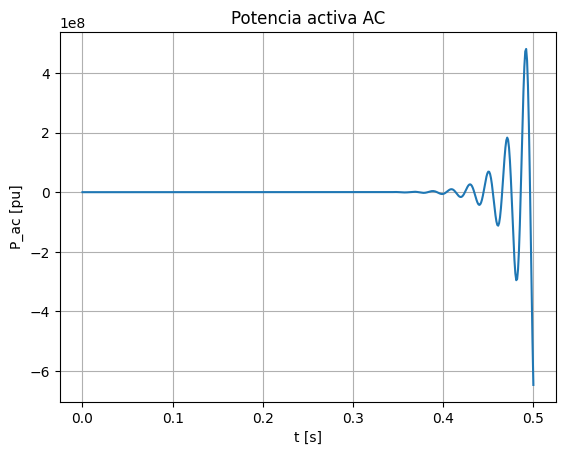

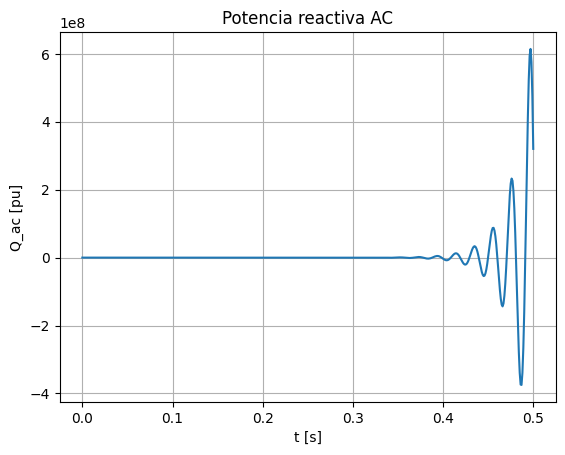

In [11]:
p_series = y_hist.get("P_ac", [])
q_series = y_hist.get("Q_ac", [])

plt.figure()
plt.plot(time, p_series)
plt.xlabel("t [s]")
plt.ylabel("P_ac [pu]")
plt.title("Potencia activa AC")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(time, q_series)
plt.xlabel("t [s]")
plt.ylabel("Q_ac [pu]")
plt.title("Potencia reactiva AC")
plt.grid(True)
plt.show()


In [12]:
# Conversión de formato para exportador
# ------------------------------------

time = results["time"]
x_raw = results["x"]       # dict con listas
y_raw = results["y"]       # dict con listas

n = len(time)

# Convertimos x: dict(list) -> list(dict)
x_hist_export = [
    {k: x_raw[k][i] for k in x_raw.keys()}
    for i in range(n)
]

# Convertimos y: dict(list) -> list(dict)
y_hist_export = [
    {k: y_raw[k][i] for k in y_raw.keys()}
    for i in range(n)
]

print("Formato listo para exportar -> filas:", len(x_hist_export))


Formato listo para exportar -> filas: 501


## Exportar resultados a CSV / Parquet

Podemos usar el módulo `vscsim.utils.exporter` para generar archivos
con las series de tiempo de la simulación.


In [ ]:
out_dir = Path("outputs")
out_dir.mkdir(parents=True, exist_ok=True)

csv_path = out_dir / "simulacion_intro.csv"
parquet_path = out_dir / "simulacion_intro.parquet"

cfg = ExportConfig(overwrite=True)

export_simulation_csv(time, x_hist_export, y_hist_export, str(csv_path), config=cfg)
print("CSV escrito en:", csv_path)

# Parquet sólo si pandas/engine están disponibles
try:
    export_simulation_parquet(time, x_hist, y_hist, str(parquet_path), config=cfg)
    print("Parquet escrito en:", parquet_path)
except Exception as exc:
    print("No se pudo escribir Parquet:", exc)


CSV escrito en: outputs\simulacion_intro.csv
No se pudo escribir Parquet: len(times) y len(x_history) deben coincidir


: 

## Resumen

En este notebook hemos visto cómo:

- Cargar parámetros y escenario desde JSON.
- Ejecutar una simulación usando `vscsim.api.simulation.run_simulation`.
- Configurar integrador, NR y logging desde Python.
- Visualizar corrientes, tensión DC y potencias.
- Exportar resultados a CSV/Parquet para análisis externo.

Los siguientes notebooks profundizarán en:
- Modo P/Q
- Modo Vdc/Q
- Comparación de integradores y dt adaptativo
